# Rhetorical and sentiment analysis

# Imports 

In [52]:
import simplejson
import numpy as np
from glob import glob
from bs4 import BeautifulSoup
from datetime import datetime
from os.path import basename, join
from pprint import pprint
import re
import pickle 
import cPickle
import pandas as pd

import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt

import sys
sys.path.append("/root/sa/edu_dependency_parser/src")
from trees.parse_tree import ParseTree

from wordcloud import WordCloud

%matplotlib inline

In [4]:
from spacy.en import English
nlp = English()

# Aspect-based sentiment analysis flow - texual data summarization 

<img src="Rhetorical analysis - Flow croped.png">

# Exemplary Discourse Tree

<img src="Rhetorical Analysis example.png">

# Load parsed data 

In [45]:
# data_path = '/datasets/sentiment/aspects/results-brexit/results/brexit-news-all/'
data_path = '/datasets/sentiment/aspects/results/brexit-event-4516937-body-no-lemma/'

In [29]:
def load_serialized(f_path, f_name):
    with open(join(f_path, f_name)) as f:
        obj = cPickle.load(f)
    return obj

In [30]:
aspect_graph = load_serialized(data_path, 'aspects_graph') 

## Sentiment EDUs load

In [40]:
sent_edu = load_serialized(data_path, 'sentiment_filtered_edus')

In [41]:
sent_edu.items()[0]

(0,
 {'raw_text': u'tx david cameron will face eu leaders today for the first time',
  'sentiment': array([1]),
  'source_document_id': 0,
  'tokens': [{'is_stop': False, 'lemma': u'tx', 'pos': u'ADP', 'text': u'tx'},
   {'is_stop': False, 'lemma': u'david', 'pos': u'PROPN', 'text': u'david'},
   {'is_stop': False, 'lemma': u'cameron', 'pos': u'NOUN', 'text': u'cameron'},
   {'is_stop': True, 'lemma': u'will', 'pos': u'VERB', 'text': u'will'},
   {'is_stop': False, 'lemma': u'face', 'pos': u'VERB', 'text': u'face'},
   {'is_stop': False, 'lemma': u'eu', 'pos': u'NOUN', 'text': u'eu'},
   {'is_stop': False, 'lemma': u'leader', 'pos': u'NOUN', 'text': u'leaders'},
   {'is_stop': False, 'lemma': u'today', 'pos': u'NOUN', 'text': u'today'},
   {'is_stop': True, 'lemma': u'for', 'pos': u'ADP', 'text': u'for'},
   {'is_stop': True, 'lemma': u'the', 'pos': u'DET', 'text': u'the'},
   {'is_stop': True, 'lemma': u'first', 'pos': u'ADJ', 'text': u'first'},
   {'is_stop': False, 'lemma': u'time',

## Aspects load 

In [11]:
aspect_edu = load_serialized(data_path, 'aspects_per_edu')

### Summarize sentiment per aspect

In [18]:
def graph_stats(graph):
    n_n = len(graph.nodes())
    n_e = len(graph.edges())
    print '#Nodes: {}'.format(n_n)
    print '#Edges: {}'.format(n_e)
    print 'Connections coverage: {}%'.format(( float(n_e) / (n_n * n_n ) * 100))

    degree_sequence=sorted(nx.degree(graph).values(),reverse=True) # degree sequence
    dmax=max(degree_sequence)

    print '-'*30
    print 'Highest degree of nodes'
    nd=sorted(aspect_graph.degree_iter(), key=itemgetter(1), reverse=True)
    df_nd = pd.DataFrame(nd, columns=['aspect', 'degree'])
    #     pprint([x for x in nd if len(x[0]) > 1]) # filter out aspect consists of one letter

    print '-'*30
    print 'Page Rank'
    pg = nx.pagerank(aspect_graph)
    df_pg = pd.DataFrame(pg.items(), columns=['aspect', 'pagerank'])
    # pgs = [(node, pagerank) for node, pagerank in pg.items()]
    #     pprint(pgs[:top_n])
    print '-'*30
    pprint('Unique Values of Page Rank: {}, unique nodes: {}'.format(len(set([pagerank for node, pagerank in pg.items()])), n_n))
    doc_asp_sent = []
    for doc_id, aspects in aspect_edu.iteritems():
        for aspect in aspects:
            doc_asp_sent.append((aspect, sent_edu[doc_id]['sentiment'][0]))

    df = pd.DataFrame()
    df['aspect'] = [x[0] for x in doc_asp_sent]
    df['sentiment'] = [x[1] for x in doc_asp_sent]

    df_mean = df.groupby('aspect').mean().reset_index().sort_values('sentiment', ascending=False)
    df_mean.columns = ['aspect', 'mean_sent']
    df_sum = df.groupby('aspect').sum().reset_index().sort_values('sentiment', ascending=False)
    df_sum.columns = ['aspect', 'sum_sent']

    df = pd.merge(df_mean, df_sum, on='aspect')
    df = pd.merge(df, df_pg, on='aspect')
    df = pd.merge(df, df_nd, on='aspect')

    df = df[[u'aspect', u'mean_sent', u'sum_sent', 'pagerank', 'degree']]

    return doc_asp_sent, df

In [19]:
doc_asp_sent, df = graph_stats(aspect_graph)

#Nodes: 21600
#Edges: 5632390
Connections coverage: 1.20721664952%
------------------------------
Highest degree of nodes
------------------------------
Page Rank
------------------------------
'Unique Values of Page Rank: 19947, unique nodes: 21600'


In [13]:
aspects_to_remove = ['day', 'days', 'week', 'weeks', 'month', 'months', 'year', 'years', 'monday', 'tuesday', 'wednesday', 
                     'thursday', 'friday', 'saturday', 'sunday', 'january', 'february', 'march', 'april', 'may', 'june', 'july',
                     'august', 'september', 'october', 'november', 'december']

In [84]:
df_filtered = df[(df.aspect.str.len() > 1) & (~df.aspect.isin(aspects_to_remove))]#.head(50)

### UK related aspect and different sentiment orientation 

In [126]:
df_filtered[df_filtered.aspect.isin(['great britain', 'united kingdom', 'uk', 'u.k'])].sort_values('pagerank', ascending=False)

,aspect,mean_sent,sum_sent,pagerank,degree
12028,u.k,-0.379366,-467,0.004203,8921
10128,uk,0.405689,542,0.003822,22110
10664,united kingdom,0.115746,111,0.001579,14074
9185,great britain,0.979695,386,0.001526,5578


## Page Rank based aspect  

In [91]:
def draw_wordcloud(counts):
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(counts)
    plt.figure(figsize=(9, 12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [137]:
df_filtered.sort_values('pagerank', ascending=False).head(50)

,aspect,mean_sent,sum_sent,pagerank,degree
10154,britain,0.393472,4894,0.031807,31020
10663,vote,0.117008,485,0.012642,23978
12288,eu,-0.542575,-2415,0.010735,31629
12355,country,-0.596593,-1751,0.009720,22404
11686,brexit,-0.246844,-567,0.007181,27704
10124,scotland,0.411281,1400,0.006202,20774
10463,europe,0.292705,634,0.006031,24887
11559,referendum,-0.161318,-377,0.005815,25092
11741,london,-0.316799,-677,0.005570,18671
11708,bloc,-0.266639,-653,0.005548,14566


In [133]:
def draw_top_aspects_by_col(df=df_filtered, col='pagerank', top_n=100, ascending=False, pagerank_min=0.0005):
    counts = []
    for _, row in df[df.pagerank > pagerank_min].sort_values(col, ascending=ascending).head(top_n)[['aspect', col]].iterrows():
        counts.append((row['aspect'], row[col]))
    draw_wordcloud(counts)

### TOP100 aspects based on pagerank

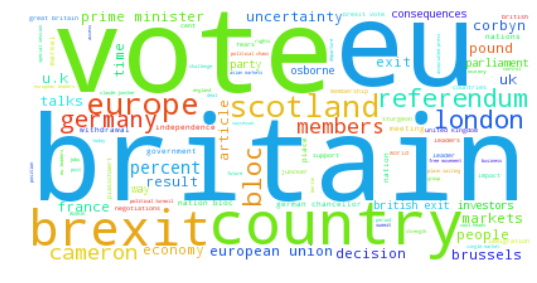

In [135]:
draw_top_aspects_by_col(col='pagerank', top_n=100)

## Sentiment of the aspects 

### Positive

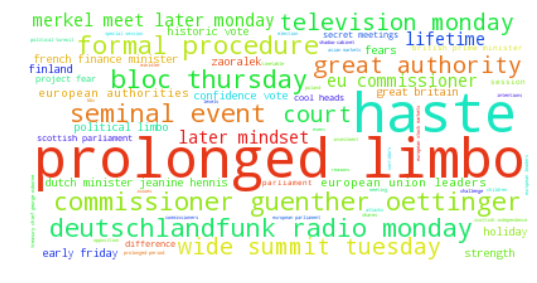

In [131]:
draw_top_aspects_by_col(col='mean_sent')

### Negative

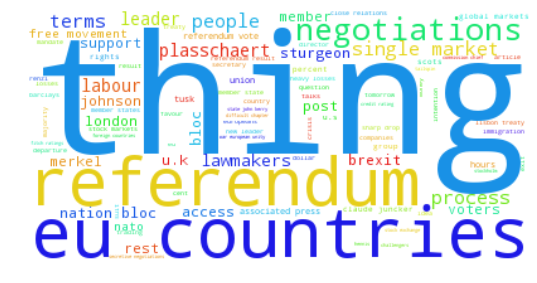

In [141]:
draw_top_aspects_by_col(col='mean_sent', ascending=True)

## Problems
###1. Time of parsing [Rhetorical Parsing]

## Next steps and improvements

###1. Change aspects (noun and noun phases) -> concepts
###2. Extend approach with type of connection between EDU (clausses)
###3. Compare aspects derived for different sources, timeframes, topics etc.
###4. Build the timeline of aspects and sentiment orientation 